In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from analysis.data import load_yaml, load_file_contents
from common import load_correctness_data, load_fixation_data
import pathlib
import common
from analysis import np_utils
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

In [2]:
fixations = pd.read_parquet("../data/processed/fixations-fixed.parq")
# dropped_data = load_yaml('../data/raw/invalid_eyetracking_data.yaml')
# for pid, tids in dropped_data.items():
#     for tid in tids:
#         fixations = fixations.drop((pid, tid), errors='ignore')

correctness = load_correctness_data()
correctness = correctness.query('snippet != "distance"').copy()
correctness = correctness.set_index(['pid', 'tid'])
fixations = fixations.join(correctness)
annotations = load_yaml("../data/raw/annotations.yaml")
source_root = pathlib.Path("../data/raw/snippets")
source_index = {
    v["file"]: load_file_contents(source_root / v["file"])
    for k, v in annotations.items()
}

fixations = fixations.dropna(subset=['correct', 'snippet'])

In [3]:
from analysis import metrics

all_metrics = [
    metrics.regression_rate,
    metrics.line_regression_rate,
    metrics.horizontal_later,
    metrics.vertical_later,
    metrics.vertical_next,
]
metric_names = [fn.__name__ for fn in all_metrics]

grouper = fixations.groupby(level=[0, 1])
linearity_metrics = grouper.apply(lambda df: pd.Series({
    fn.__name__: fn(df) for fn in all_metrics
}))
linearity_metrics = linearity_metrics.join(correctness).dropna()

In [4]:
linearity_metrics.groupby('correct').median()

/var/folders/9t/pnh1mqks36vfw7ngs3d7n8r00000gn/T/ipykernel_43964/1333894048.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  linearity_metrics.groupby('correct').median()


,regression_rate,line_regression_rate,horizontal_later,vertical_later,vertical_next
correct,,,,,
False,0.453046,0.154822,0.224359,0.703829,0.469880
True,0.458987,0.162520,0.232082,0.699577,0.464649


In [5]:
print(
    linearity_metrics.reset_index(drop=True)
    .groupby(["snippet"])
    .median()
    .dropna()
    .drop(columns=["correct"])
    .reset_index()
    .to_latex(index=False, float_format="%.3f")
)


\begin{tabular}{lrrrrr}
\toprule
       snippet &  regression\_rate &  line\_regression\_rate &  horizontal\_later &  vertical\_later &  vertical\_next \\
\midrule
   calculation &            0.459 &                 0.175 &             0.247 &           0.711 &          0.433 \\
   graph\_utils &            0.450 &                 0.159 &             0.244 &           0.719 &          0.525 \\
insertion\_sort &            0.461 &                 0.152 &             0.234 &           0.686 &          0.464 \\
   money\_class &            0.473 &                 0.155 &             0.196 &           0.673 &          0.464 \\
number\_checker &            0.454 &                 0.161 &             0.217 &           0.675 &          0.437 \\
   numbers\_hrd &            0.469 &                 0.149 &             0.204 &           0.675 &          0.465 \\
   numbers\_hrn &            0.457 &                 0.172 &             0.247 &           0.713 &          0.505 \\
     rectangle &  

/var/folders/9t/pnh1mqks36vfw7ngs3d7n8r00000gn/T/ipykernel_43964/554433447.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  linearity_metrics.reset_index(drop=True)


In [30]:
linearity_metrics.groupby(['snippet', 'correct']).median().dropna()

regression_rate  line_regression_rate  \
snippet        correct                                          
calculation    False           0.467421              0.141704   
               True            0.457143              0.176471   
graph_utils    False           0.451330              0.152340   
               True            0.429464              0.179227   
insertion_sort False           0.461121              0.150198   
               True            0.456388              0.157047   
money_class    False           0.472362              0.162479   
               True            0.473600              0.150490   
number_checker False           0.463226              0.163871   
               True            0.453893              0.155833   
numbers_hrd    False           0.440324              0.138851   
               True            0.469307              0.151648   
numbers_hrn    False           0.458964              0.168166   
               True            0.457163              0.172131   
rectangle      False           0.441613              0.181122   
               True            0.444785              0.155172   

                        horizontal_later  vertical_later  vertical_next  
snippet        correct                                                   
calculation    False            0.197006        0.675213       0.715832  
               True             0.252252        0.712903       0.735294  
graph_utils    False            0.234189        0.705897       0.796142  
               True             0.285629        0.751375       0.820806  
insertion_sort False            0.214286        0.685065       0.766727  
               True             0.245872        0.696696       0.756241  
money_class    False            0.207705        0.688442       0.815745  
               True             0.187682        0.671653       0.759146  
number_checker False            0.211613        0.699355       0.770323  
               True             0.219406        0.671601       0.715509  
numbers_hrd    False            0.205306        0.695382       0.759119  
               True             0.204082        0.668213       0.784257  
numbers_hrn    False            0.231270        0.713971       0.790333  
               True             0.250000        0.709459       0.794623  
rectangle      False            0.267157        0.728372       0.773153  
               True             0.255255        0.721116       0.726994

* Check line lengths for horizontal_later (money class vs rectangle)

### Metrics w/ Perceived Difficulty/Years of Experience

In [40]:
experiment_metadata = pd.read_parquet('../data/processed/experiment_metadata.parq')

print(experiment_metadata.columns)
experiment_metadata = experiment_metadata.join(linearity_metrics, lsuffix='_meta').dropna()

assert len(linearity_metrics) == len(experiment_metadata), f"{len(linearity_metrics)} != {len(experiment_metadata)}"

Index(['snippet', 'perceived_difficulty', 'years_of_experience',
       'coded_perceived_difficulty'],
      dtype='object')


In [93]:
experiment_metadata.groupby("snippet")["coded_perceived_difficulty"].describe().dropna()

,count,mean,std,min,25%,50%,75%,max
snippet,,,,,,,,
calculation,17.0,1.941176,1.028992,1.0,1.0,2.0,2.0,4.0
graph_utils,22.0,3.590909,0.796366,2.0,3.0,4.0,4.0,5.0
insertion_sort,15.0,2.666667,1.543033,1.0,1.0,3.0,4.0,5.0
money_class,15.0,1.800000,0.414039,1.0,2.0,2.0,2.0,2.0
number_checker,15.0,1.866667,0.516398,1.0,2.0,2.0,2.0,3.0
numbers_hrd,21.0,2.047619,1.116969,1.0,1.0,2.0,3.0,4.0
numbers_hrn,29.0,2.310345,1.365479,1.0,1.0,3.0,3.0,5.0
rectangle,21.0,1.619048,0.669043,1.0,1.0,2.0,2.0,3.0


In [95]:
experiment_metadata.groupby("snippet")["correct"].mean().dropna()

snippet
calculation       0.764706
graph_utils       0.272727
insertion_sort    0.400000
money_class       0.933333
number_checker    0.933333
numbers_hrd       0.809524
numbers_hrn       0.655172
rectangle         0.523810
Name: correct, dtype: float64

Text(0.5, 0.98, 'Linearity metrics by years of experience')

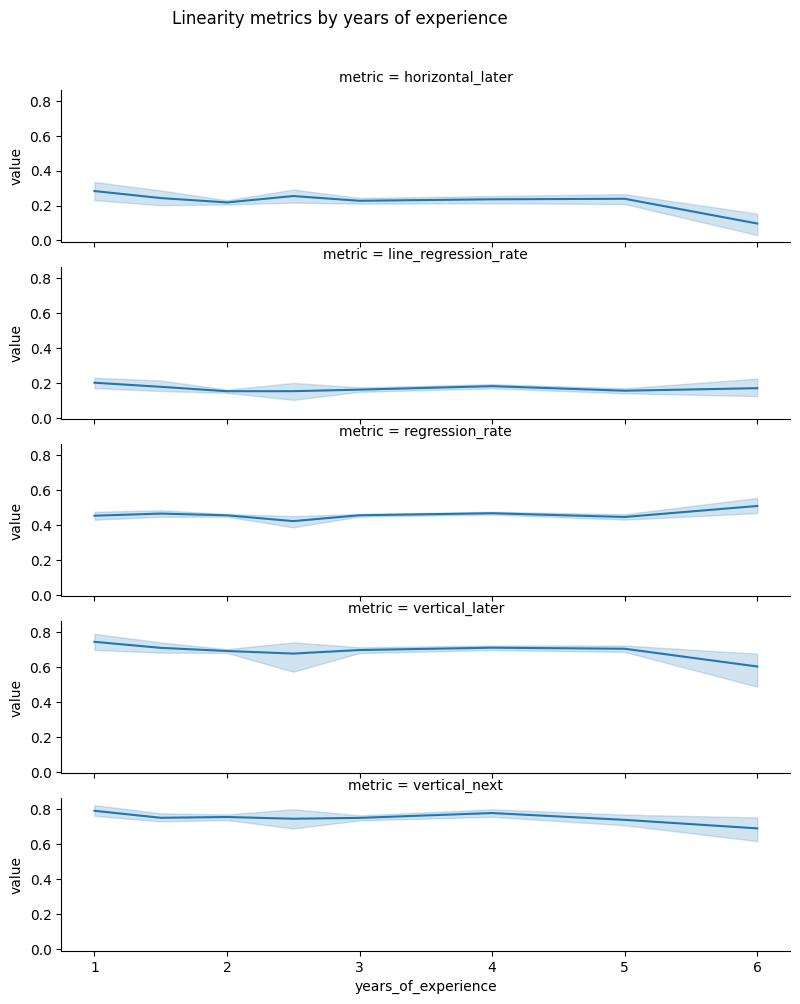

In [70]:
melted_metrics_with_metadata = experiment_metadata.reset_index().melt(
    id_vars=[
        "pid",
        "tid",
        "snippet",
        "correct",
        "years_of_experience",
        "coded_perceived_difficulty",
    ],
    value_vars=metric_names,
    var_name="metric",
).astype({'metric' : 'category', 'correct': 'bool'}).set_index(['pid', 'tid'])


g = sns.FacetGrid(data=melted_metrics_with_metadata, row='metric')

g.map_dataframe(sns.lineplot, y='value', x='years_of_experience')

g.figure.set_size_inches(10, 10)
g.fig.subplots_adjust(top=0.9)
g.figure.suptitle('Linearity metrics by years of experience')

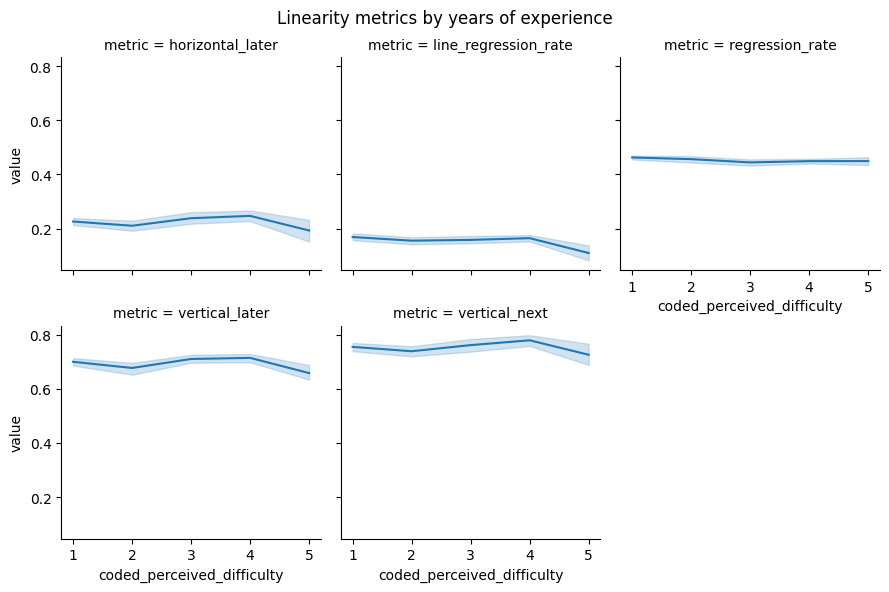

In [77]:
g = sns.FacetGrid(data=melted_metrics_with_metadata, col='metric',  col_wrap=3)

g.map_dataframe(sns.lineplot, y='value', x='coded_perceived_difficulty')

g.fig.subplots_adjust(top=0.9)
g.figure.suptitle('Linearity metrics by years of perceived difficulty');

## Linearity of Reading Order

In [81]:
def parse_model_sequence(lines_or_tuples):
    res = []
    for line in lines_or_tuples:
        if isinstance(line, (tuple, list)):
            res.extend(list(range(line[0], line[1] + 1)))
        else:
            res.append(line)
    return res


def get_reading_order_models(annotations, source_index):
    results = {}
    for snippet_name, contents in annotations.items():
        reading_orders = contents["reading_orders"]
        source = source_index[contents["file"]]
        source_lines = source.splitlines()
        results[snippet_name] = {}
        for reading_order, line_sequence in reading_orders.items():
            line_order = parse_model_sequence(line_sequence)
            # offset by 1 to account for 1-indexing in yaml
            line_order = [line - 1 for line in line_order]
            # remove empty lines
            line_order = [
                line for line in line_order if len(source_lines[line].strip()) > 0
            ]
            results[snippet_name][reading_order] = line_order
    return results


def create_binned_fixation_sequence(durations, line_numbers, binsize=10):
    repeats = np.round(durations / binsize).astype(int)
    return np.repeat(line_numbers, repeats)


def create_unique_fixation_sequence(line_numbers):
    return line_numbers[(line_numbers != np_utils.shift(line_numbers))]


import numpy as np
from minineedle import core


def compute_alignment_scores(sample_df, get_gaze_seq):
    lines = sample_df["source_file_line"].values.copy()
    durations = sample_df["duration"].values.copy()

    reading_order_model_index = get_reading_order_models(annotations, source_index)

    snippet = sample_df['snippet'].values[0]
    results = {}
    for model_key, reading_order in reading_order_model_index[snippet].items():
        gaze_seq = get_gaze_seq(durations, lines)
        score = common.normalized_alignment_score(
            reading_order, gaze_seq, core.ScoreMatrix(match=3, miss=-3, gap=-2)
        )
        results[model_key] = score

    return pd.Series(results)


import functools

get_binned_gaze_seq = functools.partial(create_binned_fixation_sequence, binsize=80)
compute_naive_alignment_binned = functools.partial(
    compute_alignment_scores, get_gaze_seq=get_binned_gaze_seq
)

compute_naive_alignment_no_bins = functools.partial(
    compute_alignment_scores,
    get_gaze_seq=lambda durations, lines: create_unique_fixation_sequence(lines),
)
naive_linearity_binned = (
    fixations.dropna(subset=["snippet"])
    .groupby(level=[0, 1])
    .apply(compute_naive_alignment_binned)
).join(correctness)
naive_linearity_no_bins= (
    fixations.dropna(subset=["snippet"])
    .groupby(level=[0, 1])
    .apply(compute_naive_alignment_no_bins)
).join(correctness)

# fixations.astype({'snippet': 'category'})['snippet'].unique()


In [25]:
naive_linearity_binned.groupby(['correct']).median()

/var/folders/9t/pnh1mqks36vfw7ngs3d7n8r00000gn/T/ipykernel_67656/2792288038.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  naive_linearity_binned.groupby(['correct']).median()


,story_order,execution_order
correct,,
False,-0.466307,-0.466312
True,-0.449822,-0.453586


In [41]:
naive_linearity_no_bins.groupby(['correct']).median()

/var/folders/9t/pnh1mqks36vfw7ngs3d7n8r00000gn/T/ipykernel_9186/543643131.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  naive_linearity_no_bins.groupby(['correct']).median()


,story_order,execution_order
correct,,
False,-0.583951,-0.585417
True,-0.548148,-0.546057


In [44]:
naive_linearity_no_bins.groupby(['snippet']).median().dropna().to_clipboard()

In [43]:
naive_linearity_no_bins.groupby(['snippet', 'correct']).median().dropna().to_clipboard()

In [33]:
open_source = ['numbers_hrd', 'numbers_hrn', 'graph_utils']
naive_linearity_no_bins.loc[naive_linearity_no_bins['snippet'].isin(open_source), 'type'] = 'opensource'
naive_linearity_no_bins.loc[~naive_linearity_no_bins['snippet'].isin(open_source), 'type'] = 'synthesize'
print(naive_linearity_no_bins.groupby(['type']).median().dropna()
naive_linearity_no_bins.groupby(['type']).mean()

/var/folders/9t/pnh1mqks36vfw7ngs3d7n8r00000gn/T/ipykernel_67656/885885050.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  naive_linearity_no_bins.groupby(['type']).mean()


,story_order,execution_order,correct
type,,,
opensource,-0.33858,-0.349238,0.612500
synthesize,-0.27672,-0.263464,0.705882


In [86]:
cols_to_drop=['correct', 'snippet']
all_metrics = naive_linearity_no_bins.drop(columns=cols_to_drop).join(linearity_metrics.drop(columns=cols_to_drop))

all_metrics.to_parquet('../data/interim/linearity-metrics.parq')

In [29]:
naive_linearity_binned.groupby(['snippet']).median().dropna()

,story_order,execution_order,correct
snippet,,,
calculation,-0.469463,-0.451730,1.0
graph_utils,-0.469231,-0.465472,0.0
insertion_sort,-0.467399,-0.452516,0.0
money_class,-0.422568,-0.425888,1.0
number_checker,-0.438080,-0.433036,1.0
numbers_hrd,-0.449822,-0.455166,1.0
numbers_hrn,-0.464490,-0.475526,1.0
rectangle,-0.447712,-0.457474,1.0


In [ ]:
naive_linearity_no_bins.groupby(['snippet']).median().dropna()

In [17]:
def compute_alignment_scores_dynamic(sample_df):
    lines = sample_df['source_file_line'].values.copy()
    durations = sample_df['duration'].values.copy()
    gaze_seq = create_binned_fixation_sequence(durations, lines, binsize=50)

    reading_order_model_index = get_reading_order_models(annotations, source_index)

    snippet = sample_df['snippet'].unique()[0]
    results = {}
    for model_key, reading_order in reading_order_model_index[snippet].items():
        best_score = -np.inf
        best_repeats = 1 
        repeats = 1 
        while len(reading_order) * repeats < len(gaze_seq):
            # print(len(reading_order) * repeats, len(gaze_seq))
            model_seq = reading_order * repeats
            curr_score = common.normalized_alignment_score(model_seq, gaze_seq, core.ScoreMatrix(match=3, miss=-3, gap=-2))
            if curr_score > best_score:
                best_score =  curr_score
                best_repeats = repeats
            repeats += 1
        results[model_key] = best_score
        results[f"{model_key}_repeats"] = best_repeats
    
    return pd.Series(results)

dynamic_linearity = fixations.dropna(subset=['snippet']).groupby(level=[0, 1]).apply(compute_alignment_scores_dynamic)
dynamic_linearity = dynamic_linearity.join(correctness)

KeyboardInterrupt: 

In [ ]:
dynamic_linearity.groupby(['correct']).median()

/var/folders/9t/pnh1mqks36vfw7ngs3d7n8r00000gn/T/ipykernel_60951/1181063758.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dynamic_linearity.groupby(['correct']).median()


,story_order,execution_order
correct,,
False,-3690.5,-3703.0
True,-1674.0,-1673.0


In [ ]:
dynamic_linearity.groupby(['snippet']).median()

,story_order,execution_order,correct
snippet,,,
calculation,-1297.0,-1283.0,1.0
graph_utils,-4587.0,-4570.0,0.0
insertion_sort,-2162.0,-2168.0,0.0
money_class,-519.0,-520.0,1.0
number_checker,-911.0,-927.0,1.0
numbers_hrd,-3135.0,-3135.0,1.0
numbers_hrn,-4814.0,-4850.0,1.0
rectangle,-1518.0,-1555.0,1.0


In [27]:
fixations.groupby(['correct']).median()

/var/folders/9t/pnh1mqks36vfw7ngs3d7n8r00000gn/T/ipykernel_9186/1375430851.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fixations.groupby(['correct']).median()


,fixation_id,left_pupil_diameter,right_pupil_diameter,x,y,position_interpolated,valid,interpolated,n,start_time,end_time,duration,source_file_line,source_file_col
correct,,,,,,,,,,,,,,
False,424.0,16.294709,15.813380,560.916667,543.000000,11.0,0.411765,0.0,19.0,1.650932e+12,1.650932e+12,156.0,287.0,17.0
True,307.0,16.244795,16.534276,557.388889,512.090909,11.0,0.400000,0.0,19.0,1.651257e+12,1.651257e+12,155.0,447.0,16.0


In [48]:
snippet = 'insertion-sort-with-bug.cpp'
fixations[fixations['gaze_target'] == snippet].groupby(level=[0, 1]).apply(lambda df: df.iloc[0])

,,fixation_id,left_pupil_diameter,right_pupil_diameter,x,y,gaze_target,position_interpolated,valid,interpolated,n,start_time,end_time,duration,source_file_line,source_file_col,snippet,correct
pid,tid,,,,,,,,,,,,,,,,,
p100,t4,6.0,17.280673,15.818765,537.066667,438.666667,insertion-sort-with-bug.cpp,13,0.133333,0,15,1.670447e+12,1.670447e+12,108.0,23,17,insertion_sort,False
p103,t2,4.0,16.320513,16.729003,432.055556,311.055556,insertion-sort-with-bug.cpp,11,0.388889,0,18,1.670460e+12,1.670460e+12,130.0,8,5,insertion_sort,False
p104,t4,0.0,14.881284,15.200472,587.428571,782.178571,insertion-sort-with-bug.cpp,17,0.392857,0,28,1.670529e+12,1.670529e+12,221.0,37,21,insertion_sort,False
p105,t2,0.0,13.601938,16.108824,370.333333,630.000000,insertion-sort-with-bug.cpp,10,0.166667,0,12,1.670534e+12,1.670534e+12,92.0,30,0,insertion_sort,True
p106,t3,5.0,13.356759,13.801041,495.750000,504.562500,insertion-sort-with-bug.cpp,11,0.312500,0,16,1.670623e+12,1.670623e+12,115.0,27,12,insertion_sort,False
p87,t1,0.0,13.881241,13.153039,646.300000,150.200000,insertion-sort-with-bug.cpp,8,0.200000,0,10,1.669848e+12,1.669848e+12,82.0,16,26,insertion_sort,False
p88,t2,1.0,15.414796,14.168672,385.833333,140.722222,insertion-sort-with-bug.cpp,14,0.222222,0,18,1.669852e+12,1.669852e+12,138.0,1,2,insertion_sort,False
p89,t3,0.0,14.702270,14.982307,496.961538,233.769231,insertion-sort-with-bug.cpp,8,0.692308,0,26,1.669934e+12,1.669934e+12,198.0,18,14,insertion_sort,True
p90,t3,1.0,16.284182,15.876583,456.513514,727.594595,insertion-sort-with-bug.cpp,23,0.324324,1,37,1.669937e+12,1.669937e+12,281.0,34,13,insertion_sort,False
